In [2]:
# turn data - previous 5 turns
# state data - cumulative turn data
# base data - matchup

# GT - winner

### REGRESSOR 3 - base data

In [156]:
import pandas as pd

display(winners := pd.read_csv('datasets/clean/winners.tsv', header=None, index_col=None, sep='\t').values)

array([[7.500e+01, 1.100e+02, 1.050e+02, ..., 1.063e+03, 1.000e+03,
        1.000e+00],
       [8.500e+01, 6.000e+01, 1.000e+02, ..., 1.591e+03, 1.537e+03,
        0.000e+00],
       [3.500e+01, 5.500e+01, 4.000e+01, ..., 1.569e+03, 1.680e+03,
        0.000e+00],
       ...,
       [7.400e+01, 7.500e+01, 7.000e+01, ..., 1.000e+03, 1.000e+03,
        0.000e+00],
       [2.000e+01, 1.000e+01, 5.500e+01, ..., 1.000e+03, 1.000e+03,
        0.000e+00],
       [6.800e+01, 6.400e+01, 6.000e+01, ..., 1.000e+03, 1.000e+03,
        1.000e+00]])

In [157]:
from sklearn.model_selection import train_test_split

labels = winners[:, -1]
entries = winners[:, :-1]
train_X, test_X, train_y, test_y = train_test_split(entries, labels, test_size=0.3)

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge

lr = RandomForestClassifier(n_estimators=25, max_depth=10).fit(train_X, [int(x) for x in train_y])
display(lr.score(test_X, [int(x) for x in test_y]))
display(lr.score(train_X, [int(x) for x in train_y]))

testx, testy = list(zip(*sorted(list(zip(test_X, test_y)), key=lambda x: x[1])))
predy = lr.predict(testx)

0.5570668243642815

0.952079107505071

accuracy: 0.5570668243642815
precision: 0.5388349514563107
recall: 0.5461254612546126
f1 score: 0.5424557116676847


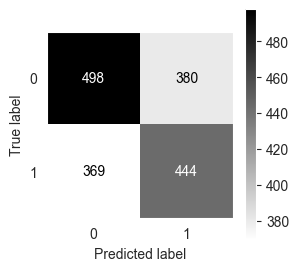

In [193]:
from matplotlib import pyplot as plt
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
evaluate_classifier(testy, predy)
plt.grid(False)



In [7]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(train_X)


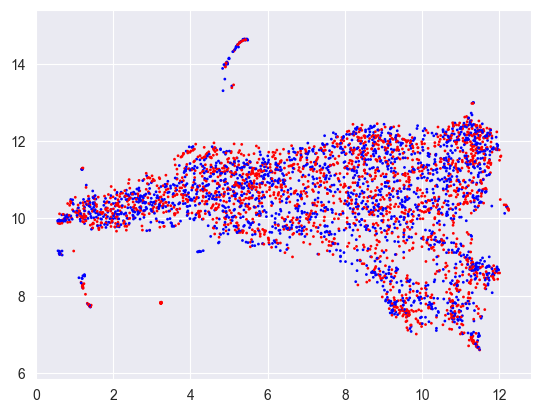

In [8]:
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x)] for x in train_y],
  s=1)
plt.gca().set_aspect('equal', 'datalim')


In [9]:
import sklearn

embedding = sklearn.decomposition.PCA(n_components=2).fit_transform(train_X)


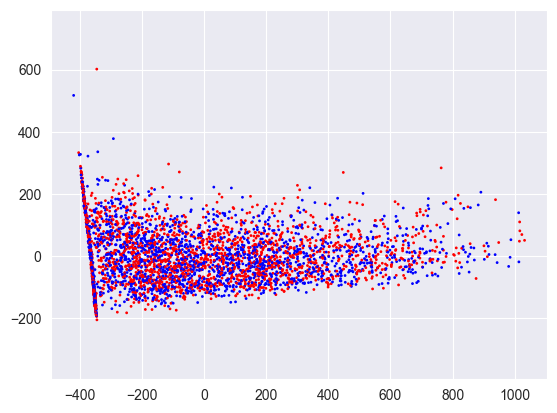

In [10]:
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x)] for x in train_y],
  s=1)
plt.gca().set_aspect('equal', 'datalim')

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

regressor = DecisionTreeClassifier()
regressor.fit(train_X, train_y.astype(int))
regressor.score(test_X, test_y.astype(int))


0.5470136014192786

precision: 0.5089820359281437
recall: 0.5029585798816568
f1: 0.5059523809523809
accuracy: 0.5091661738616203


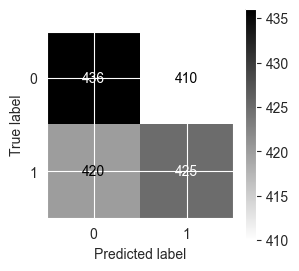

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

predy = regressor.predict(test_X)
plt.rcParams['figure.figsize'] = [3, 3]

testy = [int(x) for x in testy]
disp = ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(testy, predy))
disp.plot(cmap='binary')
print(f'precision: {precision_score(testy, predy)}')
print(f'recall: {recall_score(testy, predy)}')
print(f'f1: {f1_score(testy, predy)}')
print(f'accuracy: {accuracy_score(testy, predy)}')



### CNN BASED

In [13]:
import json

import numpy as np

ti, tl, tei, tel = [], [], [], []
for SLICESIZE in [5, 10, 15, 20]:
  with open(f'datasets/clean/slices_{SLICESIZE}.json') as fl:
    _data = json.load(fl)

  train_images, train_labels = list(zip(
    *[(np.array(img), label) for img, label in
      zip(_data['train_X'], _data['train_y'])
      if np.array(img).shape == np.array(_data['train_X'][0]).shape]
  ))

  test_images, test_labels = list(zip(
    *[(np.array(img), label) for img, label in
      zip(_data['test_X'], _data['test_y'])
      if np.array(img).shape == np.array(_data['test_X'][0]).shape]
  ))

  train_labels, test_labels = np.array(train_labels, dtype=int), np.array(test_labels, dtype=int)

  img = np.mean(train_images, axis=0)
  train_images = [x / img.max(axis=0) for x in train_images]
  test_images = [x / img.max(axis=0) for x in test_images]
  train_images, test_images = np.array(train_images), np.array(test_images)

  train_images = train_images.reshape(len(train_labels), SLICESIZE, 38, 1)
  test_images = test_images.reshape(len(test_labels), SLICESIZE, 38, 1)

  ti.append(train_images)
  tl.append(train_labels)
  tei.append(test_images)
  tel.append(test_labels)



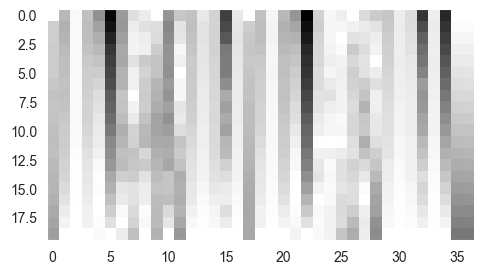

In [14]:
plt.figure(figsize=(10, 3))
all_images = np.concatenate((train_images, test_images), axis=0)
img = np.mean(all_images, axis=0)
plt.grid(False)
plt.imshow(img / img.max(axis=0), cmap='gray')

train_images = [x / img.max(axis=0) for x in train_images]
test_images = [x / img.max(axis=0) for x in test_images]
train_images, test_images = np.array(train_images), np.array(test_images)

In [204]:
from sklearn.metrics import confusion_matrix

def evaluate_classifier(y_true, y_pred):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
  disp.plot(cmap='binary')
  print(f'accuracy: {accuracy_score(np.squeeze(y_true), np.squeeze(y_pred)):0.3f}')
  print(f'precision: {precision_score(np.squeeze(y_true), np.squeeze(y_pred)):0.3f}')
  print(f'recall: {recall_score(np.squeeze(y_true), np.squeeze(y_pred)):0.3f}')
  print(f'f1 score: {f1_score(np.squeeze(y_true), np.squeeze(y_pred)):0.3f}')


In [16]:
from keras.callbacks import EarlyStopping
from keras import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#### SIZEFIVE MODEL


In [17]:
import tensorflow as tf

models = []
param_filter = [2, 4, 8, 8]
image_shape = [5, 10, 15, 20]

for i in range(0, len(image_shape)):
  train_X, train_y, test_X, test_y = ti[i], tl[i], tei[i], tel[i]
  val = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(64)
  mod = Sequential()
  """
  mod.add(Conv2D(16, (min(param_filter[i]//2, 6), 30), activation='relu', input_shape=(image_shape[i], 38, 1)))
  mod.add(MaxPooling2D((2, 4)))
  mod.add(Conv2D(32*(1 + i//1.5), (2, 2), activation='relu'))
  """
  mod.add(Flatten())
  mod.add(Dense(512, activation='relu'))
  mod.add(Dropout(0.5))
  mod.add(Dense(32, activation='relu'))
  mod.add(Dropout(0.2))
  mod.add(Dense(1, activation='sigmoid'))

  mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=[], run_eagerly=True)

  early_stop = EarlyStopping(monitor='val_loss', patience=3)

  history = mod.fit(train_X, train_y.astype(float), epochs=50, batch_size=128, validation_data=val,
                    callbacks=[early_stop])

  models.append(mod)


Epoch 1/50
174/174 [==============================] - 6s 32ms/step - loss: 0.7771 - val_loss: 0.6909
Epoch 2/50
174/174 [==============================] - 5s 30ms/step - loss: 0.6879 - val_loss: 0.6839
Epoch 3/50
174/174 [==============================] - 5s 30ms/step - loss: 0.6784 - val_loss: 0.6711
Epoch 4/50
174/174 [==============================] - 5s 29ms/step - loss: 0.6688 - val_loss: 0.6578
Epoch 5/50
174/174 [==============================] - 5s 29ms/step - loss: 0.6597 - val_loss: 0.6579
Epoch 6/50
174/174 [==============================] - 5s 30ms/step - loss: 0.6514 - val_loss: 0.6480
Epoch 7/50
174/174 [==============================] - 5s 29ms/step - loss: 0.6457 - val_loss: 0.6461
Epoch 8/50
174/174 [==============================] - 5s 29ms/step - loss: 0.6366 - val_loss: 0.6476
Epoch 9/50
174/174 [==============================] - 5s 29ms/step - loss: 0.6268 - val_loss: 0.6401
Epoch 10/50
174/174 [==============================] - 5s 29ms/step - loss: 0.6210 - val_lo

296/296 [==============================] - 1s 4ms/step
accuracy: 0.634
precision: 0.637
recall: 0.640
f1 score: 0.6384760309817876:0.3f
217/217 [==============================] - 1s 5ms/step
accuracy: 0.663
precision: 0.587
recall: 0.653
f1 score: 0.6179793679384312:0.3f
170/170 [==============================] - 1s 4ms/step
accuracy: 0.677
precision: 0.691
recall: 0.581
f1 score: 0.6311148435859752:0.3f
120/120 [==============================] - 1s 4ms/step
accuracy: 0.703
precision: 0.655
recall: 0.740
f1 score: 0.694765100671141:0.3f
120/120 [==============================] - 1s 7ms/step


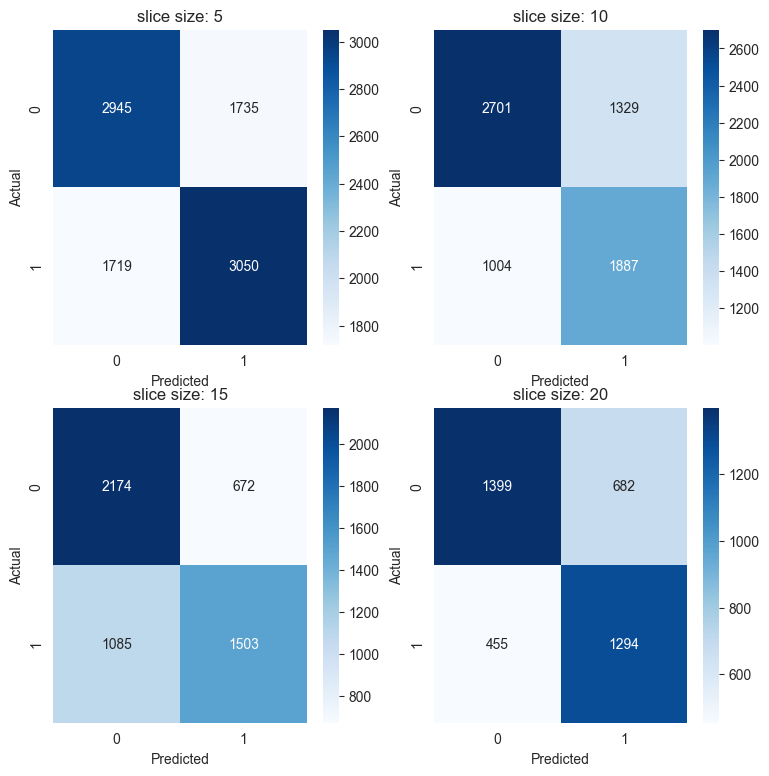

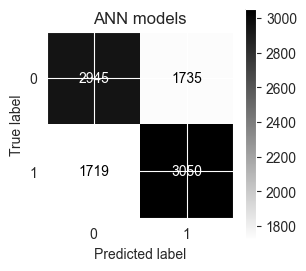

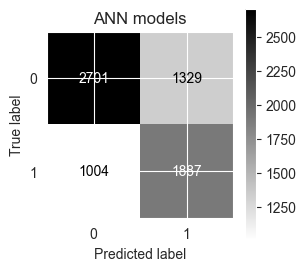

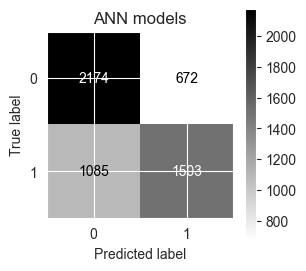

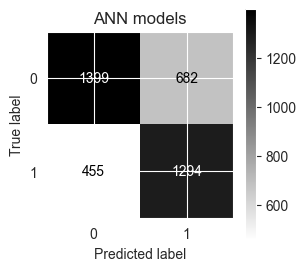

In [202]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(9, 9))
for i in range(0, len(image_shape)):
  train_X, train_y, test_X, test_y = ti[i], tl[i], tei[i], tel[i]
  evaluate_classifier(test_y.astype(float), np.squeeze(np.round(models[i].predict(test_X))))
  sns.heatmap(confusion_matrix(test_y, np.round(models[i].predict(test_X))), annot=True, fmt='d', cmap='Blues',
              ax=ax[i // 2][i % 2])
  ax[i // 2][i % 2].set_title(f'slice size: {image_shape[i]}')
  ax[i // 2][i % 2].set_xlabel('Predicted')
  ax[i // 2][i % 2].set_ylabel('Actual')
  plt.title('ANN models')


Confusion Matrix for 5 slices
accuracy: 0.649
precision: 0.662
recall: 0.623
f1 score: 0.642
-----------------------------------------------

Confusion Matrix for 10 slices
accuracy: 0.668
precision: 0.588
recall: 0.680
f1 score: 0.631
-----------------------------------------------

Confusion Matrix for 15 slices
accuracy: 0.678
precision: 0.668
recall: 0.645
f1 score: 0.656
-----------------------------------------------

Confusion Matrix for 20 slices
accuracy: 0.716
precision: 0.686
recall: 0.696
f1 score: 0.691
-----------------------------------------------



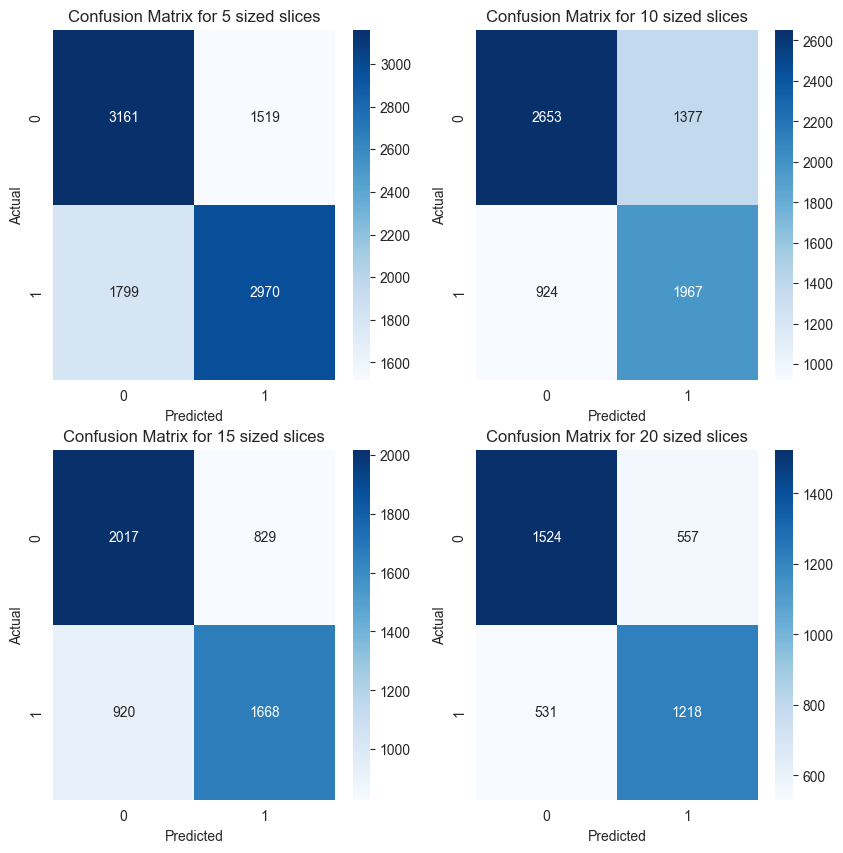

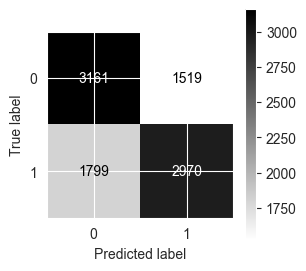

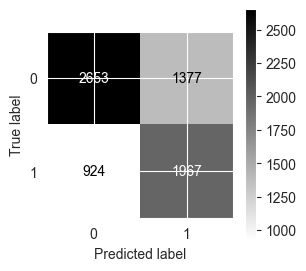

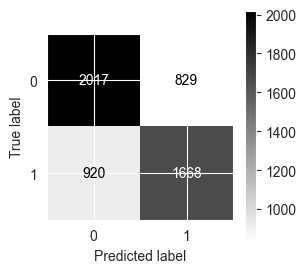

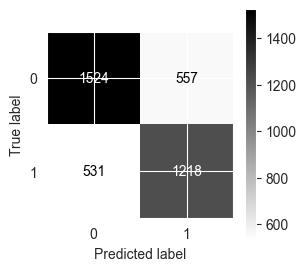

In [206]:
from xgboost import XGBClassifier

model_xgboost = []
param_filter = [2, 4, 8, 8]
slice = [5, 10, 15, 20]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(len(param_filter)):
  train_X, train_y, test_X, test_y = ti[i], tl[i], tei[i], tel[i]

  train_X = np.sum(train_X, axis=1)
  test_X = np.sum(test_X, axis=1)

  train_X = train_X.reshape(len(train_y), 38)
  test_X = test_X.reshape(len(test_y), 38)

  clf = XGBClassifier(n_estimators=100, max_depth=20, random_state=144)
  clf.fit(train_X, train_y)
  y_pred = clf.predict(test_X)

  print(f"Confusion Matrix for {slice[i]} slices")
  evaluate_classifier(test_y, y_pred)
  sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[i // 2][i % 2])
  ax[i // 2][i % 2].set_title(f'Confusion Matrix for {image_shape[i]} sized slices')
  ax[i // 2][i % 2].set_xlabel('Predicted')
  ax[i // 2][i % 2].set_ylabel('Actual')
  print('-----------------------------------------------')
  print()

  model_xgboost.append(clf)


Confusion Matrix for 5 slices
accuracy: 0.673
precision: 0.628
recall: 0.696
f1 score: 0.660
-----------------------------------------------

Confusion Matrix for 10 slices
accuracy: 0.675
precision: 0.682
recall: 0.598
f1 score: 0.637
-----------------------------------------------

Confusion Matrix for 15 slices
accuracy: 0.701
precision: 0.657
recall: 0.698
f1 score: 0.677
-----------------------------------------------

Confusion Matrix for 20 slices
accuracy: 0.699
precision: 0.691
recall: 0.664
f1 score: 0.677
-----------------------------------------------



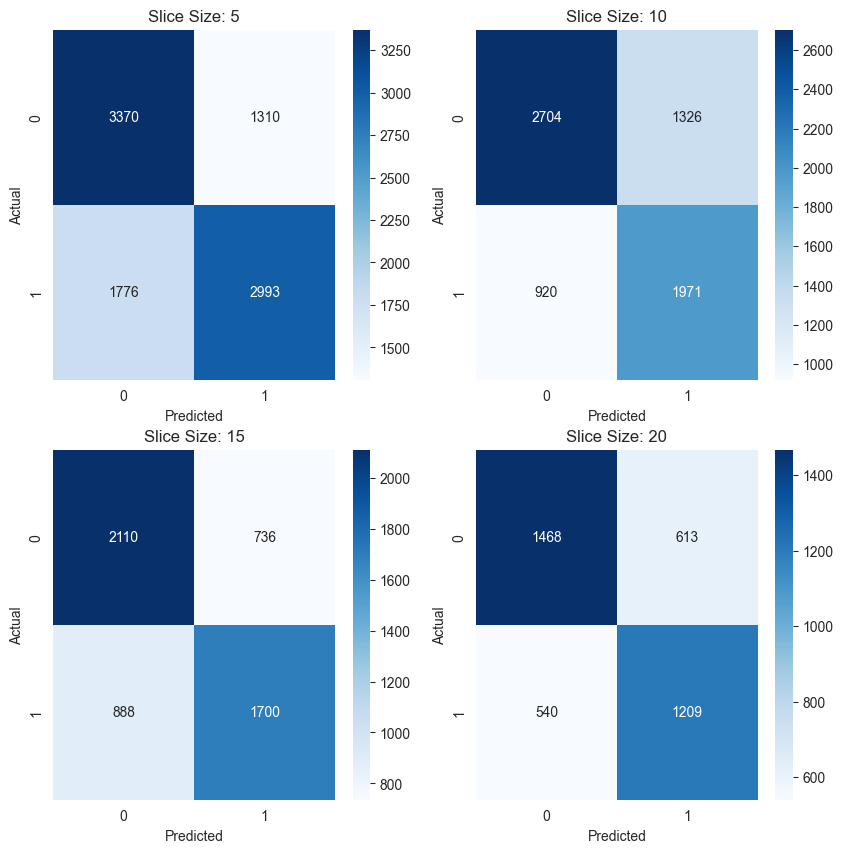

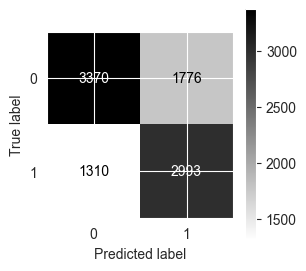

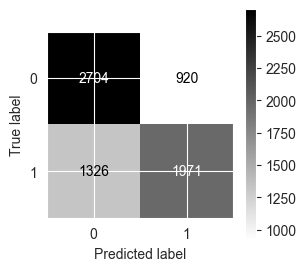

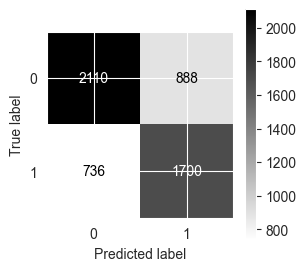

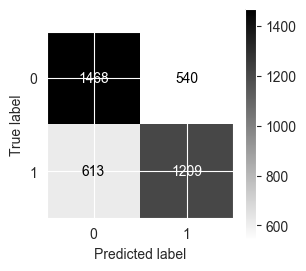

In [207]:
from sklearn.ensemble import RandomForestClassifier

model_RF = []
param_filter = [2, 4, 8, 8]
slice = [5, 10, 15, 20]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(len(param_filter)):
  train_X, train_y, test_X, test_y = ti[i], tl[i], tei[i], tel[i]

  train_X = np.sum(train_X, axis=1)
  test_X = np.sum(test_X, axis=1)

  train_X = train_X.reshape(len(train_y), 38)
  test_X = test_X.reshape(len(test_y), 38)

  clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
  clf.fit(train_X, train_y)
  y_pred = clf.predict(test_X)
  print(f"Confusion Matrix for {slice[i]} slices")
  evaluate_classifier(y_pred, test_y)
  sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[i // 2][i % 2])
  ax[i // 2][i % 2].set_title(f'Slice Size: {image_shape[i]}')
  ax[i // 2][i % 2].set_xlabel('Predicted')
  ax[i // 2][i % 2].set_ylabel('Actual')
  print('-----------------------------------------------')
  print()

  model_RF.append(clf)


In [135]:
import math
from sklearn.metrics import r2_score

class Evaluator():
  def __init__(self, clf, train_X, train_y, cumulative=False):
    train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, train_size=0.5)
    self.model = LinearRegression()
    self.cumulative = cumulative
    self.clf = clf

    train_X_ = np.array([np.sum(img, axis=0) for img in train_X]).reshape(train_X.shape[0], 38)
    test_X_ = np.array([np.sum(img, axis=0) for img in test_X]).reshape(test_X.shape[0], 38)
    if cumulative:
      train_X, test_X = train_X_, test_X_
    try:
      train_y_pred = np.round(clf.predict(train_X, verbose=0))
      test_y_pred = np.round(clf.predict(test_X, verbose=0))
    except TypeError:
      train_y_pred = np.round(clf.predict(train_X))
      test_y_pred = np.round(clf.predict(test_X))
    self.model.fit(train_X_, train_y_pred)
    self.confidence = math.exp(r2_score(np.round(self.model.predict(test_X_)), test_y_pred)) / math.e
    display(self.confidence)

  def weights(self, test_X):
    test_X = np.array([np.sum(img, axis=0) for img in test_X]).reshape(test_X.shape[0], 38)
    return np.squeeze(self.model.predict(test_X) * self.confidence)

  def predict(self, test_X):
    test_X_ = np.array([np.sum(img, axis=0) for img in test_X]).reshape(test_X.shape[0], 38)
    if self.cumulative: test_X = test_X_
    try:
      return np.squeeze(np.round(self.clf.predict(test_X, verbose=0))).astype(int)
    except TypeError:
      return np.squeeze(np.round(self.clf.predict(test_X))).astype(int)



In [136]:
evaluators = [[], [], [], []]
for i in range(4):
  evaluators[i].append(Evaluator(models[i], tei[i], tel[i]))
  evaluators[i].append(Evaluator(model_RF[i], tei[i], tel[i], True))
  evaluators[i].append(Evaluator(model_xgboost[i], tei[i], tel[i], True))

0.4738246371297967

0.4167287237088097

0.33446559250030317

0.4703151509630429

0.43982080919777916

0.38128149839861325

0.44809357825766805

0.41843065582820904

0.38771421404758

0.44761834106412673

0.4554731884843989

0.43570142017789787

In [137]:
from scipy.special import expit
from pandas import DataFrame

def evaluate(log_df: DataFrame):
  log_df = log_df.drop(['p0_winner', 'p1_winner', 'turn_norm', 'p0_pokemon', 'p1_pokemon'], axis=1)
  turn_nums = log_df.shape[0]
  if turn_nums < 5: return []

  measurements = []

  for turn in range(5, turn_nums + 1):
    slices = []
    measurement = {'preds':[], 'weights':[], 'ensembled':0}
    if turn >= 5: slices.append(log_df.iloc[turn - 5:turn])
    if turn >= 10: slices.append(log_df.iloc[turn - 10:turn])
    if turn >= 15: slices.append(log_df.iloc[turn - 15:turn])
    if turn >= 20: slices.append(log_df.iloc[turn - 20:turn])

    for i, slice in enumerate(slices):
      evaluator: Evaluator = None
      for evaluator in evaluators[i]:
        tosend = np.array([slice])
        pred = evaluator.predict(tosend)
        weight = evaluator.weights(tosend)
        measurement['preds'].append(pred)
        measurement['weights'].append(expit(weight/100))
    measurement['ensembled'] = np.average(measurement['preds'], weights=measurement['weights'])

    measurements.append(measurement)
  return measurements

In [233]:
with open('datasets/clean/next_tests.txt') as fl:
  next_tests = [x.rstrip('\n') for x in fl.readlines()][:200]

In [267]:
buckets_small = [[{'preds': [], 'weights':[]} for i in range(3)] for _ in range(5)]
boards_small = [[], [], [], []]
for battle in next_tests:
  test_data = pd.read_csv(f'datasets/clean/logs/{battle}', sep='\t')
  if test_data.shape[0] < 5: continue
  size = min(10, test_data.shape[0])
  measurements = evaluate(test_data.iloc[:size])
  winner = test_data['p1_winner'][0]
  for i in range(4, size):
    bucket = min(int((i - 4) / (size - 4) * 5), 5)
    preds = measurements[i-4]['preds']
    preds = [int(pred == winner) for pred in preds]
    weights = measurements[i-4]['weights']
    weights = [(pred*2-1) * weight for pred, weight in zip(preds, weights)]

    for j in range(3):
      buckets_small[bucket][j]['preds'].append(preds[j])
      buckets_small[bucket][j]['weights'].append(weights[j])


In [269]:
for bucket in buckets_small:
  for i in range(4):
    boards_small[i].append([])
  for evaluator in bucket:
    boards_small[0][-1].append(np.average(evaluator['preds']))
    boards_small[1][-1].append(np.average([x for x in evaluator['weights'] if x > 0]))
    boards_small[2][-1].append(np.average([x for x in evaluator['weights'] if x < 0]))
    boards_small[3][-1].append(np.average([abs(x) for x in evaluator['weights']]))

Text(0.5, 1.0, 'accuracy of prediction')

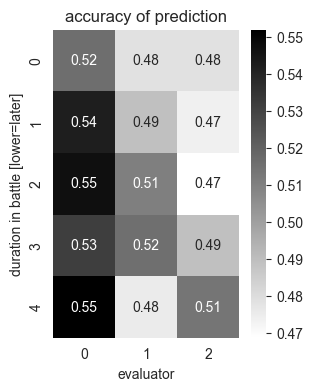

In [275]:
plt.figure(figsize=(3, 4))
plt.grid(False)
sns.heatmap(boards_small[0], cmap='binary', annot=True)
plt.xlabel('evaluator')
plt.ylabel('duration in battle [lower=later]')
plt.title('accuracy of prediction')

In [304]:
buckets = [[{'preds': [], 'weights':[]} for i in range(13)] for _ in range(10)]

for battle in next_tests:
  test_data = pd.read_csv(f'datasets/clean/logs/{battle}', sep='\t')
  if test_data.shape[0] < 20:
    continue
  measurements = evaluate(test_data)
  winner = test_data['p1_winner'][0]
  for i in range(19, test_data.shape[0]):
    bucket = min(int((i - 19) / (test_data.shape[0] - 19) * 10), 9)
    preds = measurements[i-4]['preds']
    preds = [int(pred == winner) for pred in preds]
    preds.append(int(np.round(measurements[i-4]['ensembled']) == winner))
    weights = measurements[i-4]['weights']
    weights.append(0.00)
    weights = [(pred*2-1) * weight for pred, weight in zip(preds, weights)]

    for j in range(13):
      buckets[bucket][j]['preds'].append(preds[j])
    for j in range(13):
      buckets[bucket][j]['weights'].append(weights[j])

In [305]:
#pred_board, wt_pos_board, wt_ned_board, wt_board
boards = [[], [], [], []]
for bucket in buckets:
  for i in range(4):
    boards[i].append([])
  for evaluator in bucket:
    boards[0][-1].append(np.average(evaluator['preds']))
    boards[1][-1].append(np.average([x for x in evaluator['weights'] if x > 0]))
    boards[2][-1].append(np.average([x for x in evaluator['weights'] if x < 0]))
    boards[3][-1].append(np.average([abs(x) for x in evaluator['weights']]))


C:\Users\Yash\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Yash\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'accuracy of prediction')

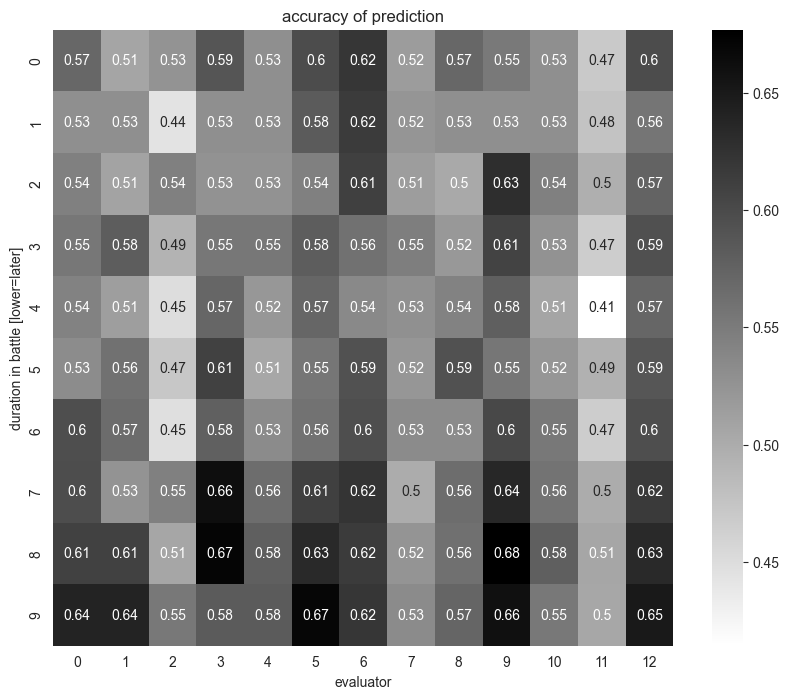

In [306]:
plt.figure(figsize=(10, 8))
plt.grid(False)
sns.heatmap(boards[0], cmap='binary', annot=True)
plt.xlabel('evaluator')
plt.ylabel('duration in battle [lower=later]')
plt.title('accuracy of prediction')

<AxesSubplot:>

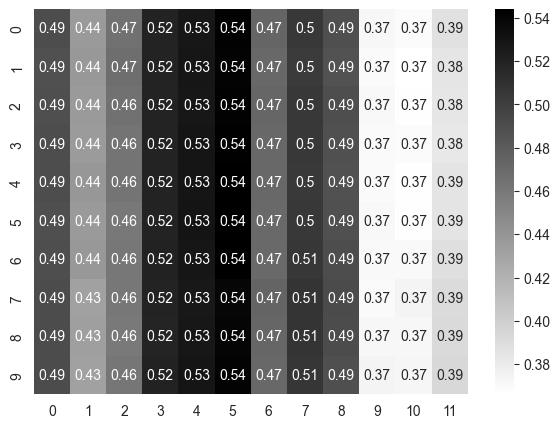

In [291]:
plt.figure(figsize=(7, 5))
plt.grid(False)
sns.heatmap(boards[1], cmap='binary', annot=True)


<AxesSubplot:>

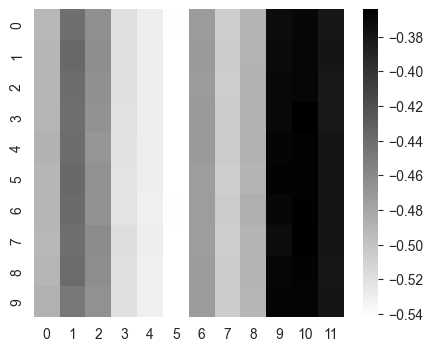

In [284]:
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.heatmap(boards[3], cmap='binary', annot=True)



<AxesSubplot:>

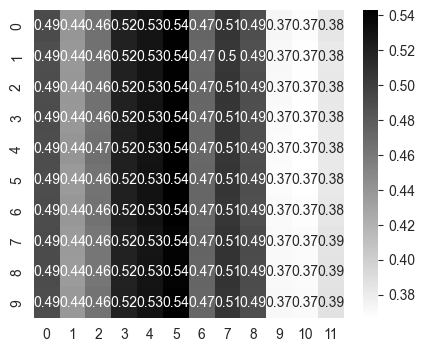

In [287]:
plt.figure(figsize=(5, 4))
plt.grid(False)